[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [12]:

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [42]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [
    AIMessage("So you said you were researching ocean mammals?", name="Bot"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance")
]

messages1 = [
    AIMessage("hi how are you", name="Bot1"),
    HumanMessage("I am fine", name="Lance1")
]
for m in messages:
    m.pretty_print()
for m in messages1:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot1

hi how are you
================================ Human Message =================================
Name: Lance1

I am fine


Recall we can pass them to a chat model.

In [45]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)
llm.invoke(messages1)

AIMessage(content='Glad to hear that! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 24, 'total_tokens': 36, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb3c3cb84d', 'id': 'chatcmpl-CSk3Sun0M5PWTrwELmCPTVuXfAh7t', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--b9aa6289-0ea5-41cf-a02c-a647a48fd898-0', usage_metadata={'input_tokens': 24, 'output_tokens': 12, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

We can run our chat model in a simple graph with `MessagesState`.

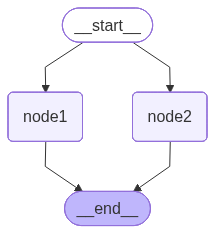

In [50]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
class MyState(TypedDict):
    messages: list
    messages1: list

# --- Node 1 ---
def node1(state):
    res = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [res]}

# --- Node 2 ---
def node2(state):
    res = llm.invoke(state["messages1"])
    return {"messages1": state["messages1"] + [res]}

# --- Build graph ---
builder = StateGraph(MyState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_edge(START, "node1")
builder.add_edge(START, "node2")
builder.add_edge("node1", END)
builder.add_edge("node2", END)
graph = builder.compile()

# --- Inputs ---
messages = [
    AIMessage("So you said you were researching ocean mammals?"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?")
]
messages1 = [
    AIMessage("Hi, how are you?"),
    HumanMessage("I’m fine!")
]

# --- Run graph ---
output = graph.invoke({
    "messages": messages,
    "messages1": messages1
})
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
print("\n=== Conversation 1 ===")
for m in output["messages"]:
    print(m.content)

print("\n=== Conversation 2 ===")
for m in output["messages1"]:
    print(m.content)


=== Conversation 1 ===
So you said you were researching ocean mammals?
Yes, I know about whales. But what others should I learn about?
In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller with different anatomy, such as a shorter beak and spade-shaped teeth.

3. **Seals and Sea Lions**: Often confused with each other, seals lack external ear flaps and move on land differently compared to sea lions, which are more agile both on land and in water.

4. **Walruses**: Known for their distinctive tusks and whiskers, these large pinnipeds have a unique role in Arctic ecosystems.

5. **Manatees and Dugongs**: Sometimes referred to as sea cows, these gentle herbivores spend their days grazing on sea grasses and are primarily found in warm coastal waters.

6. **Sea Ot

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

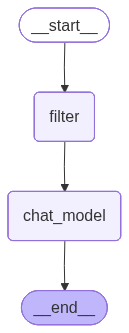

In [51]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: There are nearly 90 species of dolphins, including oceanic ones like the common bottlenose dolphin and river species like the Amazon river dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller and with different shaped teeth, porpoises can be interesting to compare and contrast with their more famous relatives.

3. **Seals**: There are two main families of seals—the true seals, such as the harbor seal, and the eared seals, such as fur seals and sea lions. They differ mainly in their anat

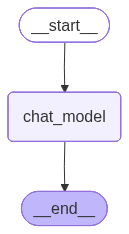

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you can learn about:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are closely related to whales and are found in oceans worldwide.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial features, porpoises are also part of the cetacean family.

3. **Seals**: These pinnipeds are agile swimmers 

In [55]:


def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_edge(START, "chat_model")
builder.add_node("chat_model", chat_model_node)
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

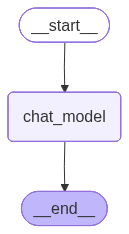

In [17]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [18]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [19]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins** - These highly intelligent creatures are known for their playful behavior. They often travel in groups called pods and use echolocation to navigate and hunt.

2. **Porpoises** - Similar to dolphins, porpoises are smaller and have different facial structures and teeth. They are shy creatures and usually avoid boats.

3. **Seals** - Seals are pinnipeds, semi-aquatic mammals that are excellent swimmers. True seals, also known as earless seals, have flippers and are known for their blubber, which keeps

In [20]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins** - These highly intelligent creatures are known for their playful behavior. They often travel in groups called pods and use echolocation to navigate and hunt.

2. **Porpoises** - Similar to dolphins, porpoises are smaller and have different facial structures and teeth. They are shy creatures and usually avoid boats.

3. **Seals** - Seals are pinnipeds, semi-aquatic mammals that are excellent swimmers. True seals, also known as earless seals, have flippers and are known for their blubber, which keeps

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

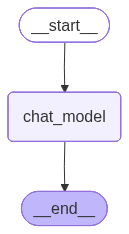

In [24]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [25]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [26]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r